# Model mismatched entity prediction analysis
In this notebook, we'll dig deeper into why the SciERC model was able to outperform the GENIA model, even though the GENIA model has more of the PICKLE corpus' vocabulary in its own vocabulary.

The approach we'll take here is to use the entities from the gold standard (PICKLE), and look at, for each of GENIA and SciERC, which of those entities were correctly predicted and which ones were not. We'll then dig deeper into the trends of which ontology types correspond most to each category, to see if differences in ontological types are responsible for the mismatches.

The script `evaluate_model_output.py` contains an option, `--save_mismatches`, which is used to generate the output used in this notebook.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size': 14})
import jsonlines
from ast import literal_eval

## Reading in the mismatches

In [3]:
all_models = pd.read_csv('../data/straying_off_topic_data/model_output/mismatch_analysis/all_dygiepp_models_mismatch_analysis_MISMATCHES.csv')

In [4]:
all_models.head()

,doc_key,mismatch_type,sent_num,ent_list,ent_type,model
0,PMID1161793_abstract,1,0,"[5, 6, 'Plant_hormone']",Plant_hormone,/mnt/ufs18/home-118/lotrecks/Shiu_lab/pickle-c...
1,PMID1161793_abstract,1,0,"[8, 8, 'Plant_hormone']",Plant_hormone,/mnt/ufs18/home-118/lotrecks/Shiu_lab/pickle-c...
2,PMID1161793_abstract,1,0,"[35, 35, 'Organic_compound_other']",Organic_compound_other,/mnt/ufs18/home-118/lotrecks/Shiu_lab/pickle-c...
3,PMID1161793_abstract,1,0,"[59, 59, 'Organic_compound_other']",Organic_compound_other,/mnt/ufs18/home-118/lotrecks/Shiu_lab/pickle-c...
4,PMID1161793_abstract,1,0,"[66, 66, 'Plant_hormone']",Plant_hormone,/mnt/ufs18/home-118/lotrecks/Shiu_lab/pickle-c...


We only want to look at the full SciERC and GENIA models, so let's separate those out:

In [5]:
keep = {'GENIA':all_models.model.unique()[2],
       'SciERC':all_models.model.unique()[-1]}
keep

{'GENIA': '/mnt/ufs18/home-118/lotrecks/Shiu_lab/pickle-corpus-code/data/straying_off_topic_data/model_output/dygiepp/16Nov2022_FINAL_PERF/model_predictions/16Nov2022_final_perf_formatted_data_genia_predictions.jsonl',
 'SciERC': '/mnt/ufs18/home-118/lotrecks/Shiu_lab/pickle-corpus-code/data/straying_off_topic_data/model_output/dygiepp/16Nov2022_FINAL_PERF/model_predictions/16Nov2022_final_perf_formatted_data_scierc_predictions.jsonl'}

In [6]:
genia = all_models[all_models['model']==keep['GENIA']]
scierc = all_models[all_models['model']==keep['SciERC']]

Now, we want to make the same df as the original, excpet with `mismatch_type_GENIA` and `mismatch_type_SciERC` as columns (instead of one `mismatch_type` column and a `moddel` column). We can do this by merging the dataframes with suffixes on columns that differ, and then drop the model columns.

In [7]:
mismatches = genia.merge(scierc, how='inner', on=['doc_key', 'sent_num', 'ent_list', 'ent_type'], suffixes=('_GENIA', '_SciERC'))
mismatches = mismatches.drop(columns=['model_SciERC', 'model_GENIA'])
mismatches.head()

,doc_key,mismatch_type_GENIA,sent_num,ent_list,ent_type,mismatch_type_SciERC
0,PMID1161793_abstract,0,0,"[0, 2, 'Multicellular_organism']",Multicellular_organism,0
1,PMID1161793_abstract,0,0,"[5, 6, 'Plant_hormone']",Plant_hormone,1
2,PMID1161793_abstract,0,0,"[8, 8, 'Plant_hormone']",Plant_hormone,1
3,PMID1161793_abstract,0,0,"[11, 13, 'Organic_compound_other']",Organic_compound_other,0
4,PMID1161793_abstract,0,0,"[15, 15, 'Organic_compound_other']",Organic_compound_other,1


## Count mismatches of each category
Now that we have the mismatches for all entities for both models in one dataframe, we can count the mismatches for all the potential categories:
1. Both models correctly identify a gold standard entity
2. SciERC correctly identifies, GENIA does not
3. GENIA correctly identifies, SciERC does not
4. Both models do not identify a gold standard entity

In [8]:
both_correct = mismatches[(mismatches['mismatch_type_GENIA'] == 1) & (mismatches['mismatch_type_SciERC'] == 1)]
scierc_correct = mismatches[(mismatches['mismatch_type_GENIA'] == 0) & (mismatches['mismatch_type_SciERC'] == 1)]
genia_correct = mismatches[(mismatches['mismatch_type_GENIA'] == 1) & (mismatches['mismatch_type_SciERC'] == 0)]
neither_correct = mismatches[(mismatches['mismatch_type_GENIA'] == 0) & (mismatches['mismatch_type_SciERC'] == 0)]

In [9]:
[both_correct.shape[0], scierc_correct.shape[0], genia_correct.shape[0], neither_correct.shape[0]]

[214, 681, 67, 452]

In [10]:
# Common-sense check to make sure thhe masks worked
sum([both_correct.shape[0], scierc_correct.shape[0], genia_correct.shape[0], neither_correct.shape[0]])

1414

Now, we can make a figure! First we have to turn the numbers into a confusion matrix-like shape:

In [11]:
conf_mat = np.asarray([[both_correct.shape[0], scierc_correct.shape[0]],
           [genia_correct.shape[0], neither_correct.shape[0]]])
conf_mat_df = pd.DataFrame(conf_mat, columns=['Correct', 'Incorrect'], index=['Correct', 'Incorrect'])
conf_mat_df

,Correct,Incorrect
Correct,214,681
Incorrect,67,452


In the above dataframe, when we plot, we name the rows "SciERC" and the columns "GENIA". Let's do that:

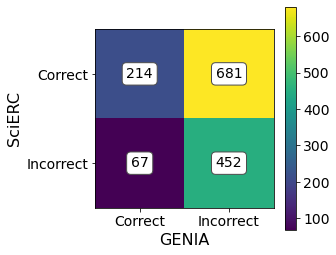

In [12]:
plt.matshow(conf_mat_df)
plt.colorbar()
tick_marks = np.arange(len(conf_mat_df.columns))
plt.xticks(tick_marks, conf_mat_df.columns)
ax = plt.gca()
ax.xaxis.set_ticks_position('bottom')
plt.yticks(tick_marks, conf_mat_df.index)
plt.ylabel('SciERC', fontsize=16)
plt.xlabel('GENIA', fontsize=16)
for i in range(2):
    for j in range(2):
        text = ax.text(j, i, conf_mat_df.iloc[i,j], ha='center', va='center',
            bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))
        
plt.savefig('../data/straying_off_topic_data/model_output/mismatch_analysis/mismatch_heatmap.png', bbox_inches='tight', dpi=600)

## Examining type trends in each category
Now we want to dig into what the trends are for what the labels are in each category. We'll look at a few things:
1. What types appear in each category?
2. What types appear in all categories? For those that don't appear in all, which ones appear where?
3. For each type, what percentage of each category does it make up?

We'll then make a stacked bar plot to visualize these trends.

In [13]:
both_types = both_correct.ent_type.unique()
scierc_types = scierc_correct.ent_type.unique()
genia_types = genia_correct.ent_type.unique()
neither_types = neither_correct.ent_type.unique()

In [14]:
type_dict = {'both':both_types, 'scierc':scierc_types, 'genia':genia_types, 'neither':neither_types}

### 1. What types appear in each category?

In [15]:
print('Types in each category:')
print('------------------------')
print(f'Correctly indentified by both models:\n{both_types}')
print(f'\nCorrectly identified by SciERC only:\n{scierc_types}')
print(f'\nCorrrectly identified by GENIA only:\n{genia_types}')
print(f'\nNot correctly identified by either model:\n{neither_types}')

Types in each category:
------------------------
Correctly indentified by both models:
['Protein' 'DNA' 'RNA' 'Plant_hormone' 'Multicellular_organism' 'Cell'
 'Organic_compound_other' 'Peptide' 'Polynucleotide' 'Tissue'
 'Amino_acid_monomer' 'Plant_region']

Correctly identified by SciERC only:
['Plant_hormone' 'Organic_compound_other' 'Multicellular_organism'
 'Biochemical_pathway' 'Inorganic_compound_other' 'Plant_region' 'Protein'
 'RNA' 'Inorganic_compound' 'Biochemical_process' 'Virus' 'Cell' 'DNA'
 'Tissue' 'Polynucleotide' 'Unicellular_organism' 'Amino_acid_monomer'
 'Element' 'Peptide']

Corrrectly identified by GENIA only:
['Protein' 'RNA' 'Multicellular_organism' 'DNA' 'Cell' 'Plant_hormone'
 'Organic_compound_other']

Not correctly identified by either model:
['Multicellular_organism' 'Organic_compound_other' 'Plant_hormone' 'Cell'
 'Tissue' 'Inorganic_compound_other' 'Element' 'Protein'
 'Biochemical_process' 'DNA' 'Virus' 'Biochemical_pathway' 'Plant_region'
 'RNA' 'Peptid

### 2. What types appear in all categories? For those that don't appear in all, which ones appear where?

Types that appear in all categories:

In [16]:
all_cats = set(both_types).intersection(set(scierc_types), set(genia_types), set(neither_types))
print(f'The types that appear in all categories are:\n--------------------------------------------\n{all_cats}')

The types that appear in all categories are:
--------------------------------------------
{'DNA', 'Organic_compound_other', 'Multicellular_organism', 'Protein', 'Cell', 'RNA', 'Plant_hormone'}


Types that do not appear in all categories, but may occur in more than one:

In [17]:
not_common_dict = {}
print('Types that do not appear in all categories, but may occur in more than one:')
print('----------------------------------------------------------------------------')
for key, value in type_dict.items():
    not_common = set(value) - all_cats
    print(f'The types that appear in {key}_types but not in all categories are:\n{not_common}\n')
    not_common_dict[key] = not_common

Types that do not appear in all categories, but may occur in more than one:
----------------------------------------------------------------------------
The types that appear in both_types but not in all categories are:
{'Polynucleotide', 'Plant_region', 'Peptide', 'Amino_acid_monomer', 'Tissue'}

The types that appear in scierc_types but not in all categories are:
{'Element', 'Inorganic_compound_other', 'Virus', 'Polynucleotide', 'Plant_region', 'Peptide', 'Biochemical_pathway', 'Unicellular_organism', 'Amino_acid_monomer', 'Inorganic_compound', 'Biochemical_process', 'Tissue'}

The types that appear in genia_types but not in all categories are:
set()

The types that appear in neither_types but not in all categories are:
{'Element', 'Inorganic_compound_other', 'Virus', 'Plant_region', 'Biochemical_pathway', 'Peptide', 'Amino_acid_monomer', 'Tissue', 'Inorganic_compound', 'Biochemical_process', 'Unicellular_organism'}



Types that appear only in one category:

In [18]:
only_one_dict = {}
print('Types that only appear in one category:')
print('----------------------------------------')
for key, value in type_dict.items():
    other_keys = list(type_dict.keys())
    other_keys.remove(key)
    all_other_sets = set().union(*[set(type_dict[k]) for k in other_keys])
    only_one = set(value) - all_other_sets
    print(f'Types that only appear in {key}_types:\n{only_one}')
    only_one_dict[key] = only_one

Types that only appear in one category:
----------------------------------------
Types that only appear in both_types:
set()
Types that only appear in scierc_types:
set()
Types that only appear in genia_types:
set()
Types that only appear in neither_types:
set()


Types that appear in SciERC correct but not in GENIA correct:

In [19]:
print('Types that appear in SciERC correct but not GENIA correct:')
print('-----------------------------------------------------------')
set(scierc_types) - set(genia_types)

Types that appear in SciERC correct but not GENIA correct:
-----------------------------------------------------------


{'Amino_acid_monomer',
 'Biochemical_pathway',
 'Biochemical_process',
 'Element',
 'Inorganic_compound',
 'Inorganic_compound_other',
 'Peptide',
 'Plant_region',
 'Polynucleotide',
 'Tissue',
 'Unicellular_organism',
 'Virus'}

### 3. For each type, what percentage of each category does it make up?
Here, we'll start making figures to get a better understanding of what's going on, as just looking at lists of types in the above sections isn't actually helpful.

In [20]:
all_ent_types = mismatches.ent_type.unique()
all_ent_types

array(['Multicellular_organism', 'Plant_hormone',
       'Organic_compound_other', 'Protein', 'DNA', 'Cell', 'RNA',
       'Tissue', 'Biochemical_pathway', 'Inorganic_compound_other',
       'Element', 'Plant_region', 'Inorganic_compound',
       'Biochemical_process', 'Virus', 'Peptide', 'Unicellular_organism',
       'Polynucleotide', 'Amino_acid_monomer'], dtype=object)

In [21]:
type_dict

{'both': array(['Protein', 'DNA', 'RNA', 'Plant_hormone', 'Multicellular_organism',
        'Cell', 'Organic_compound_other', 'Peptide', 'Polynucleotide',
        'Tissue', 'Amino_acid_monomer', 'Plant_region'], dtype=object),
 'scierc': array(['Plant_hormone', 'Organic_compound_other',
        'Multicellular_organism', 'Biochemical_pathway',
        'Inorganic_compound_other', 'Plant_region', 'Protein', 'RNA',
        'Inorganic_compound', 'Biochemical_process', 'Virus', 'Cell',
        'DNA', 'Tissue', 'Polynucleotide', 'Unicellular_organism',
        'Amino_acid_monomer', 'Element', 'Peptide'], dtype=object),
 'genia': array(['Protein', 'RNA', 'Multicellular_organism', 'DNA', 'Cell',
        'Plant_hormone', 'Organic_compound_other'], dtype=object),
 'neither': array(['Multicellular_organism', 'Organic_compound_other',
        'Plant_hormone', 'Cell', 'Tissue', 'Inorganic_compound_other',
        'Element', 'Protein', 'Biochemical_process', 'DNA', 'Virus',
        'Biochemical_pathw

In [22]:
dfs = {'both':both_correct, 'scierc':scierc_correct, 'genia':genia_correct, 'neither':neither_correct}
type_percentages = {'both':{k:0 for k in all_ent_types}, 'scierc':{k:0 for k in all_ent_types},
                    'genia':{k:0 for k in all_ent_types}, 'neither':{k:0 for k in all_ent_types}}

for model_group, df in dfs.items():
    for type_str in all_ent_types:
        identified_total = len(df.ent_type)
        identified_this_type = len(df[df['ent_type'] == type_str].ent_type)
        identified_fraction = identified_this_type/identified_total
        type_percentages[model_group][type_str] = identified_fraction

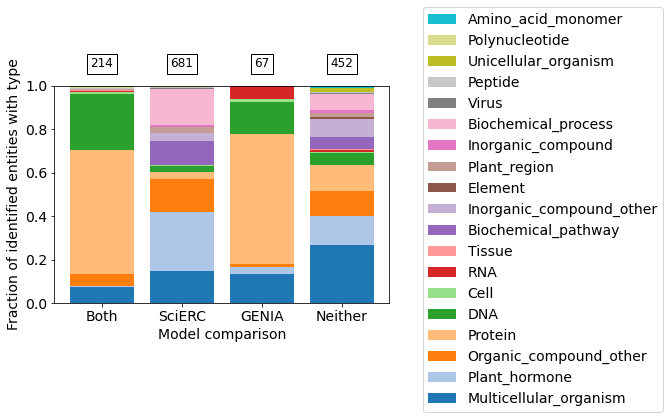

In [23]:
keys_for_labels = ['both', 'scierc', 'genia', 'neither']
labels = ['Both', 'SciERC', 'GENIA', 'Neither']
total_ents = {'Both':both_correct.shape[0], 'SciERC':scierc_correct.shape[0], 'GENIA':genia_correct.shape[0], 'Neither':neither_correct.shape[0]}

fig, ax = plt.subplots()
colors = [plt.cm.tab20(i) for i in range(20)]
vals_list = []
for i, type_str in enumerate(all_ent_types):
    vals = [type_percentages[k][type_str] for k in keys_for_labels]
    if i == 0:
        ax.bar(labels, vals, label=type_str, color=colors[i])
    else:
        ax.bar(labels, vals, bottom=sum(vals_list), label=type_str, color=colors[i])
    vals_list.append(np.asarray(vals))

# Add total number of entities identified over the bars
xtick_locs, xtick_labels = ax.get_xticks(), ax.get_xticklabels()
for xtick_loc, xtick_label in zip(xtick_locs, labels):
    box_text = f'{total_ents[xtick_label]}'
    t = ax.text(xtick_loc, 1.1, box_text, ha='center', va='center',
                 size=12, bbox=dict(boxstyle="square,pad=0.3", facecolor='white'))
    
ax.set_ylabel('Fraction of identified entities with type')
ax.set_xlabel('Model comparison')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc=(1.1,-0.5))

plt.savefig('../data/straying_off_topic_data/model_output/mismatch_analysis/type_percentages_stacked_bar.png', bbox_inches='tight', dpi=600)

This plot is quite informative! You can see that SciERC is much bettter at identifying `Plant_hormone`, `Organic_compound_other`, `Biochemical_pathway` and `Biochemical_process` than GENIA is, while GENIA excels at identifying `Protein` and `DNA` and `RNA`.

**NOTE:** Do I need to normalize thie above plot? I have two separate thoughts. (1) There are different numbers of each type annotated in teh dataset, so the comparisons within bars could just be as a result of that difference (e.g. if we identified everything correctly, but the ratio of type1 : type2 : type3 in the base dataset is 3 : 2 : 1, you'd see that the bar favors type1. This makes me think I should normalize. (2) However, the comparison we're looking at here is between bars; in which case, the comparative differences we see would remain, even if we divided everything by the number of the original types. This makes me think that I shouldn't. What to do?

## Identifying specific examples of mismatches
Now that we have an overview of what the discrepancy in model predictions are with regards to ontology types, let's take a look at some specific examples of entities where these disagreements occur.

In order to do this, we need to bring in the gold standard to use the doc key, sentence number and entity list to get the text of entities. We'll make a df with the sentence and the entity for each entity in the overall df, and then we can subset by mismatch type combination and look for good examples.

In [24]:
gold_path = '../data/straying_off_topic_data/unified_annotations_processed/jsonl_files/FINAL_FOR_EVALUATION_ent_and_rel_all_gold_std_abstracts_08Nov2022.jsonl'
with jsonlines.open(gold_path) as reader:
    gold_data = []
    for obj in reader:
        gold_data.append(obj)

In [25]:
# Make dict so we can index using doc key
gold_dict = {d['doc_key']:d for d in gold_data}

In [26]:
def get_sent(doc_key, sent_num, gold_dict):
    """
    Get the sentence as a string using doc key and sentence number.
    """
    doc = gold_dict[doc_key]
    sent_list = doc['sentences'][sent_num]
    sent_str = ' '.join(sent_list)
    return sent_str
    
def get_ent_text(doc_key, sent_num, ent_list, gold_dict):
    """
    Get the text of the entity using doc key, sent number, and entity list.
    """
    doc = gold_dict[doc_key]
    doc_token_list = []
    for sent in doc['sentences']:
        for tok in sent:
            doc_token_list.append(tok)
    ent_list = literal_eval(ent_list)
    ent_start = ent_list[0]
    ent_end = ent_list[1] # End is inclusive
    ent_text = ' '.join(doc_token_list[ent_start:ent_end+1])
    return ent_text

In [27]:
v1 = np.vectorize(get_sent)
v2 = np.vectorize(get_ent_text)

In [28]:
mismatches['sent_text'] = v1(mismatches.doc_key, mismatches.sent_num, gold_dict)
mismatches['ent_text'] = v2(mismatches.doc_key, mismatches.sent_num, mismatches.ent_list, gold_dict)

In [29]:
mismatches.head()

,doc_key,mismatch_type_GENIA,sent_num,ent_list,ent_type,mismatch_type_SciERC,sent_text,ent_text
0,PMID1161793_abstract,0,0,"[0, 2, 'Multicellular_organism']",Multicellular_organism,0,Solanum laciniatum Aiton treated with Gibberel...,Solanum laciniatum Aiton
1,PMID1161793_abstract,0,0,"[5, 6, 'Plant_hormone']",Plant_hormone,1,Solanum laciniatum Aiton treated with Gibberel...,Gibberellic acid
2,PMID1161793_abstract,0,0,"[8, 8, 'Plant_hormone']",Plant_hormone,1,Solanum laciniatum Aiton treated with Gibberel...,GA3
3,PMID1161793_abstract,0,0,"[11, 13, 'Organic_compound_other']",Organic_compound_other,0,Solanum laciniatum Aiton treated with Gibberel...,[2-chloroethyl]-trimethyl ammonium chloride
4,PMID1161793_abstract,0,0,"[15, 15, 'Organic_compound_other']",Organic_compound_other,1,Solanum laciniatum Aiton treated with Gibberel...,CCC


Now that we've got our entity texts and sentences, let's pick some examples! I'm going to look for examples from the entity type that was best identified by SciERC and GENIA, respectively (`Plant_hormone` for SciERC and `Protein` for GENIA)

In [34]:
scierc_examples = mismatches[(mismatches['mismatch_type_GENIA'] == 0) & (mismatches['mismatch_type_SciERC'] == 1) & (mismatches['ent_type'] == 'Plant_hormone')]

In [39]:
scierc_examples.head()

,doc_key,mismatch_type_GENIA,sent_num,ent_list,ent_type,mismatch_type_SciERC,sent_text,ent_text
1,PMID1161793_abstract,0,0,"[5, 6, 'Plant_hormone']",Plant_hormone,1,Solanum laciniatum Aiton treated with Gibberel...,Gibberellic acid
2,PMID1161793_abstract,0,0,"[8, 8, 'Plant_hormone']",Plant_hormone,1,Solanum laciniatum Aiton treated with Gibberel...,GA3
7,PMID1161793_abstract,0,0,"[66, 66, 'Plant_hormone']",Plant_hormone,1,Solanum laciniatum Aiton treated with Gibberel...,GA3
10,PMID1161793_abstract,0,1,"[102, 102, 'Plant_hormone']",Plant_hormone,1,"Regarding the glyco-alkaloids , the highest pe...",GA3
12,PMID1161793_abstract,0,2,"[129, 129, 'Plant_hormone']",Plant_hormone,1,"On the other hand , early application of 1000 ...",GA3


In [41]:
scierc_examples.iloc[1,6]

'Solanum laciniatum Aiton treated with Gibberellic acid ( GA3 ) , [2-chloroethyl]-trimethyl ammonium chloride ( CCC ) , and their combinations at early and late stages of growth showed that early application of 2000 ppm CCC produced the greatest stem , leaves , and whole plant dry weight , followed by the combination of early application of 1000 ppm CCC and late application of 100 ppm GA3 ; whereas all GA3 treatments decreased the dry weight production compared with the controls .'

In [36]:
genia_examples = mismatches[(mismatches['mismatch_type_GENIA'] == 1) & (mismatches['mismatch_type_SciERC'] == 0) & (mismatches['ent_type'] == 'Protein')]

In [40]:
genia_examples.head()

,doc_key,mismatch_type_GENIA,sent_num,ent_list,ent_type,mismatch_type_SciERC,sent_text,ent_text
24,PMID12744517_abstract,1,0,"[5, 5, 'Protein']",Protein,0,Nonspecific lipid transfer proteins ( nsLTPs )...,nsLTPs
25,PMID12744517_abstract,1,1,"[25, 25, 'Protein']",Protein,0,Three cDNAs coding nsLTPs from grape ( Vitis v...,nsLTPs
84,PMID12777041_abstract,1,3,"[88, 88, 'Protein']",Protein,0,A total of 26 putative CBPs were identified .,CBPs
85,PMID12777041_abstract,1,5,"[113, 113, 'Protein']",Protein,0,They are homologues of previously identified C...,CBPs
252,PMID16657524_abstract,1,1,"[29, 29, 'Protein']",Protein,0,Time sequence comparisons of the amylase zymog...,amylase


In [44]:
genia_examples.iloc[2,6]

'A total of 26 putative CBPs were identified .'